In [1]:
import os
import sys
import random
import json
import collections
import itertools

import pandas as pd
import numpy as np
import scipy        
import statsmodels
from sklearn.model_selection import train_test_split

from tqdm import trange, tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
import torch.optim as optim
from torchtext.data import Field, RawField
from torchtext.data import Dataset, TabularDataset
from torchtext.data import Iterator

from annoy import AnnoyIndex

from MulticoreTSNE import MulticoreTSNE as TSNE

%matplotlib inline

pd.options.display.max_columns = 999

sns.set()

plt.rcParams["figure.figsize"] = (10,7)

In [2]:
os.getcwd()

'/home/boris/study/UT study/ACM Sigmod/sigmod/notebooks'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from sigmod_src.utils import read_json, pprint_json, path_from_spec_id, get_vector_for_spec_id, make_classes_df, get_additional_labels
from sigmod_src.embedding import Embedder, EmbeddingBagEmbedder, LSTMEmbedder

# Load data

In [5]:
LG_LABELS_PATH = '../data/raw/sigmod_large_labelled_dataset.csv'

In [6]:
labels_df = pd.read_csv(LG_LABELS_PATH)

In [7]:
labels_df.shape

(297651, 3)

In [8]:
labels_df.head()

,left_spec_id,right_spec_id,label
0,www.ebay.com//53278,www.garricks.com.au//31,1
1,www.ebay.com//24817,www.ebay.com//58782,0
2,www.ebay.com//43019,www.ebay.com//58782,0
3,www.ebay.com//42055,www.ebay.com//54403,0
4,buy.net//6145,www.ebay.com//44280,0


# Load specs df

In [9]:
specs_df = pd.read_csv('../data/processed/specs.csv')
specs_df.shape

(28132, 8)

In [10]:
specs_df[specs_df.page_title.isnull()]

,spec_id,page_title,brand,model,all_text,page_title_stem,all_text_stem,site


In [11]:
specs_df.head()

,spec_id,page_title,brand,model,all_text,page_title_stem,all_text_stem,site
0,www.ebay.com//57656,canon powershot elph 110 hs 16-1-mp digital,canon,NaN,canon powershot elph 110 hs 16-1-mp digital ca...,canon powershot elph 110 hs 16-1-mp digit,canon powershot elph 110 hs 16-1-mp digit cano...,www.ebay.com
1,www.ebay.com//60583,canon rebel 2000 35mm great case instruction b...,canon,NaN,canon rebel 2000 35mm great case instruction b...,canon rebel 2000 35mm great case instruct booklet,canon rebel 2000 35mm great case instruct book...,www.ebay.com
2,www.ebay.com//60440,canon eos rebel t3i digital slr 18 55mm 75 300...,canon,t3i,canon eos rebel t3i digital slr 18 55mm 75 300...,canon eo rebel t3i digit slr 18 55mm 75 300mm ...,canon eo rebel t3i digit slr 18 55mm 75 300mm ...,www.ebay.com
3,www.ebay.com//24139,ge c1033 10-1-mp digital 3x zoom 2 4 lcd,NaN,c1033,ge c1033 10-1-mp digital 3x zoom 2 4 lcd ge br...,ge c1033 10-1-mp digit 3x zoom 2 4 lcd,ge c1033 10-1-mp digit 3x zoom 2 4 lcd ge bran...,www.ebay.com
4,www.ebay.com//54903,vivitar clip shot digital 1-1-mp,vivitar,NaN,vivitar clip shot digital 1-1-mp vivitar brand...,vivitar clip shot digit 1-1-mp,vivitar clip shot digit 1-1-mp vivitar brand-n...,www.ebay.com


# Additional labels

In [844]:
additional_labels = get_additional_labels(labels_df, specs_df)










0it [00:00, ?it/s]








363it [00:00, 3627.50it/s]








657it [00:00, 3389.39it/s]








1110it [00:00, 3665.94it/s]








1261it [00:00, 3681.00it/s]








  0%|          | 0/41 [00:00<?, ?it/s]








 10%|▉         | 4/41 [00:11<01:44,  2.83s/it]








 12%|█▏        | 5/41 [00:11<01:17,  2.15s/it]








 34%|███▍      | 14/41 [00:20<00:48,  1.80s/it]








 46%|████▋     | 19/41 [00:27<00:36,  1.65s/it]








 59%|█████▊    | 24/41 [00:37<00:30,  1.78s/it]








 61%|██████    | 25/41 [00:45<00:56,  3.56s/it]








 63%|██████▎   | 26/41 [00:51<01:03,  4.24s/it]








 66%|██████▌   | 27/41 [00:52<00:44,  3.21s/it]








 71%|███████   | 29/41 [00:52<00:27,  2.27s/it]








 78%|███████▊  | 32/41 [00:55<00:17,  1.92s/it]








 93%|█████████▎| 38/41 [01:32<00:09,  3.18s/it]








 98%|█████████▊| 40/41 [01:32<00:02,  2.25s/it]








100%|██████████| 41/41 [01:32<00:00,  2.25s/it]

In [845]:
# additional_labels.head()

In [846]:
# additional_labels.shape

In [847]:
all_labels = pd.concat([labels_df, additional_labels], axis=0)
all_labels.shape

(1462314, 3)

# Classes df

In [13]:
classes_df = make_classes_df(labels_df)

In [14]:
classes_df.head()

,spec_id,class_
0,buy.net//5641,0
1,www.ebay.com//54217,0
2,www.ebay.com//58588,0
3,www.ebay.com//59612,0
4,www.gosale.com//849,0


In [15]:
classes_df.shape

(908, 2)

In [16]:
classes_df.class_.value_counts()

6     178
2     130
11     95
4      91
13     80
7      78
9      57
1      55
12     16
25     14
10     14
20     11
19      9
5       9
23      9
3       9
17      7
0       6
14      5
16      5
18      5
15      4
22      4
27      4
26      3
28      2
8       2
21      2
24      2
29      2
Name: class_, dtype: int64

### Add classes to specs

In [17]:
specs_df = specs_df.merge(classes_df, how='left', on='spec_id')
specs_df.head()

,spec_id,page_title,brand,model,all_text,page_title_stem,all_text_stem,site,class_
0,www.ebay.com//57656,canon powershot elph 110 hs 16-1-mp digital,canon,NaN,canon powershot elph 110 hs 16-1-mp digital ca...,canon powershot elph 110 hs 16-1-mp digit,canon powershot elph 110 hs 16-1-mp digit cano...,www.ebay.com,NaN
1,www.ebay.com//60583,canon rebel 2000 35mm great case instruction b...,canon,NaN,canon rebel 2000 35mm great case instruction b...,canon rebel 2000 35mm great case instruct booklet,canon rebel 2000 35mm great case instruct book...,www.ebay.com,NaN
2,www.ebay.com//60440,canon eos rebel t3i digital slr 18 55mm 75 300...,canon,t3i,canon eos rebel t3i digital slr 18 55mm 75 300...,canon eo rebel t3i digit slr 18 55mm 75 300mm ...,canon eo rebel t3i digit slr 18 55mm 75 300mm ...,www.ebay.com,NaN
3,www.ebay.com//24139,ge c1033 10-1-mp digital 3x zoom 2 4 lcd,NaN,c1033,ge c1033 10-1-mp digital 3x zoom 2 4 lcd ge br...,ge c1033 10-1-mp digit 3x zoom 2 4 lcd,ge c1033 10-1-mp digit 3x zoom 2 4 lcd ge bran...,www.ebay.com,NaN
4,www.ebay.com//54903,vivitar clip shot digital 1-1-mp,vivitar,NaN,vivitar clip shot digital 1-1-mp vivitar brand...,vivitar clip shot digit 1-1-mp,vivitar clip shot digit 1-1-mp vivitar brand-n...,www.ebay.com,NaN


In [18]:
specs_df.shape

(28132, 9)

In [19]:
class_vcounts = specs_df.class_.value_counts()
class_vcounts

6.0     178
2.0     130
11.0     95
4.0      91
13.0     80
7.0      78
9.0      57
1.0      55
12.0     16
10.0     14
25.0     14
20.0     11
5.0       9
3.0       9
19.0      9
23.0      9
17.0      7
0.0       6
16.0      5
14.0      5
18.0      5
22.0      4
27.0      4
15.0      4
26.0      3
8.0       2
24.0      2
28.0      2
21.0      2
29.0      2
Name: class_, dtype: int64

In [20]:
bad_classes = list(class_vcounts[class_vcounts<2].index)
bad_classes

[]

In [21]:
specs_df.shape

(28132, 9)

In [22]:
specs_df = specs_df[~specs_df.class_.isin(bad_classes)]
specs_df.shape

(28132, 9)

In [23]:
labelled_specs_df = specs_df[~specs_df.class_.isnull()].copy()
labelled_specs_df.shape

(908, 9)

In [24]:
labelled_specs_df.to_csv('../data/interim/specs_df_labelled.csv', index=None)

In [860]:
labelled_specs_df['spec_idx'] = range(len(labelled_specs_df))
labelled_specs_df.head()

,spec_id,page_title,brand,model,all_text,page_title_stem,all_text_stem,site,class_,spec_idx
2,www.ebay.com//60440,canon eos rebel t3i digital slr 18 55mm 75 300...,canon,t3i,canon eos rebel t3i digital slr 18 55mm 75 300...,canon eo rebel t3i digit slr 18 55mm 75 300mm ...,canon eo rebel t3i digit slr 18 55mm 75 300mm ...,www.ebay.com,1.0,0
5,www.ebay.com//46571,sony cyber shot dsc w130 8-1-mp digital 4x opt...,sony,dscw130,sony cyber shot dsc w130 8-1-mp digital 4x opt...,soni cyber shot dsc w130 8-1-mp digit 4x optic...,soni cyber shot dsc w130 8-1-mp digit 4x optic...,www.ebay.com,649.0,1
6,www.ebay.com//46742,nikon d810 36-3-mp digital slr body,nikon,d810,d810 36-3-mp digital slr body brand-new applic...,nikon d810 36-3-mp digit slr bodi,d810 36-3-mp digit slr bodi brand-new applic f...,www.ebay.com,344.0,2
7,www.ebay.com//44821,nikon d610 24-3-mp nikkor af 24 85mm f 3 5 4 5...,nikon,d610,d610 24-3-mp nikkor af 24 85mm f 3 5 4 5g ed v...,nikon d610 24-3-mp nikkor af 24 85mm f 3 5 4 5...,d610 24-3-mp nikkor af 24 85mm f 3 5 4 5g ed v...,www.ebay.com,71.0,3
8,www.ebay.com//60340,sony a7 alpha mirrorless digital body,sony,ilce7,sony a7 alpha mirrorless digital body sony yes...,soni a7 alpha mirrorless digit bodi,soni a7 alpha mirrorless digit bodi soni yes 2...,www.ebay.com,709.0,4


In [861]:
random_class = labelled_specs_df.sample(1).class_.values[0]

labelled_specs_df[labelled_specs_df.class_ == random_class].page_title_stem.values

array(['canon eo 7d 18-0-mp digit slr 18 135mm 75 300mm pistol grip',
       'canon eo 7d 18-0-mp digit slr bodi w batteri grip plus 013803117493',
       'canon eo 7d 18-0-mp digit slr bodi 013803117509',
       'canon eo 7d 18-0-mp digit slr bodi english version free express 013803117493',
       'canon eo 7d kit come everyth 013803117493',
       'canon eo 7d 18-0-mp digit slr 28 135mm len mani extra 013803117493',
       'canon eo 7d 18-0-mp digit slr kit w ef 18 135mm len',
       'canon eo 7d dslr 013803117493',
       'canon eo 7d digit slr kit w ef 28 135 usm len extra bat chrgr',
       'canon eo 7d 18-0-mp digit slr bodi',
       'canon eo 7d 18-0-mp digit slr bodi complet kit 013803117509',
       'canon eo 7d slr bodi 18-0-mp 4 gb lexar cf memori card 1 3814b004 013803117493',
       'canon eo 7d 18-0-mp digit slr bodi 013803117493',
       'pre stock perfect canon eo 7d digit slr bodi japan 013803117493',
       'canon eo 7d 7 len dslr kit 44 piec pro packag 013803117493',

# Obtain train/val split

In [862]:
INTERIM_PATH = '../data/interim/'
TRAIN_PATH = 'specs_train.csv'
VAL_PATH = 'specs_val.csv'

classes = labelled_specs_df.class_.unique()
val_classes = np.random.choice(classes, 0)

labelled_specs_train = labelled_specs_df[~labelled_specs_df.class_.isin(val_classes)]
labelled_specs_val = labelled_specs_df[labelled_specs_df.class_.isin(val_classes)]

labelled_specs_train.to_csv(os.path.join(INTERIM_PATH, TRAIN_PATH), index=None)
labelled_specs_val.to_csv(os.path.join(INTERIM_PATH, VAL_PATH), index=None)

labelled_specs_train.shape, labelled_specs_val.shape

((12281, 10), (0, 10))

In [863]:
def tokenize(text):
    return text.split(' ')

text_field = Field(sequential=True, tokenize=tokenize, lower=True)
label_field = Field(sequential=False, use_vocab=False, is_target=True, dtype=torch.uint8, tokenize=None, preprocessing=lambda x: int(float(x)))

In [864]:
specs_df.head()

,spec_id,page_title,brand,model,all_text,page_title_stem,all_text_stem,site,class_
0,www.ebay.com//57656,canon powershot elph 110 hs 16-1-mp digital,canon,NaN,canon powershot 110 hs 16-1-mp digital canon r...,canon powershot elph 110 hs 16-1-mp digit,canon powershot 110 hs 16-1-mp digit canon ref...,www.ebay.com,NaN
1,www.ebay.com//60583,canon rebel 2000 35mm great case instruction b...,canon,NaN,canon rebel 2000 35mm great case instruction b...,canon rebel 2000 35mm great case instruct booklet,canon rebel 2000 35mm great case instruct book...,www.ebay.com,NaN
2,www.ebay.com//60440,canon eos rebel t3i digital slr 18 55mm 75 300...,canon,t3i,canon eos rebel t3i digital slr 18 55mm 75 300...,canon eo rebel t3i digit slr 18 55mm 75 300mm ...,canon eo rebel t3i digit slr 18 55mm 75 300mm ...,www.ebay.com,1.0
3,www.ebay.com//24139,ge c1033 10-1-mp digital 3x zoom 2 4 lcd,NaN,c1033,ge c1033 10-1-mp digital 3x zoom 2 4 ge brand-...,ge c1033 10-1-mp digit 3x zoom 2 4 lcd,ge c1033 10-1-mp digit 3x zoom 2 4 ge brand-ne...,www.ebay.com,NaN
4,www.ebay.com//54903,vivitar clip shot digital 1-1-mp,vivitar,NaN,vivitar clip shot digital 1-1-mp vivitar brand...,vivitar clip shot digit 1-1-mp,vivitar clip shot digit 1-1-mp vivitar brand-n...,www.ebay.com,NaN


In [865]:
%%time
datafields = [("spec_id", None),
              ("page_title", None),
               ("brand", None),
               ("model", None),
              ("all_text", None),
              ("page_title_stem", text_field),
              ("all_text_stem", None),
              ("site", None),
             ('class_', label_field)]

full_dataset = TabularDataset.splits(
        path="../data/processed/", # the root directory where the data lies
        train='specs.csv',
        format='csv',
        skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
        fields=datafields)

train_dataset, val_dataset = TabularDataset.splits(
    path=INTERIM_PATH, # the root directory where the data lies
    train=TRAIN_PATH,
    test=VAL_PATH,
    format='csv',
    skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
    fields=datafields)

full_dataset = full_dataset[0]

CPU times: user 1.04 s, sys: 8.06 ms, total: 1.04 s
Wall time: 1.07 s


In [866]:
train_labelled_df = pd.read_csv(os.path.join(INTERIM_PATH, TRAIN_PATH))
train_labelled_df['spec_idx'] = range(len(train_labelled_df))

# train_class_lookup = train_labelled_df[~train_labelled_df.class_.isnull()].set_index('spec_idx').to_dict()['class_']
# train_spec_lookup = train_labelled_df.groupby(['class_'])['spec_idx'].agg(list).to_dict()

In [867]:
val_labelled_df = pd.read_csv(os.path.join(INTERIM_PATH, VAL_PATH))
val_labelled_df['spec_idx'] = range(len(val_labelled_df))

# val_class_lookup = val_labelled_df[~val_labelled_df.class_.isnull()].set_index('spec_idx').to_dict()['class_']
# val_spec_lookup = val_labelled_df.groupby(['class_'])['spec_idx'].agg(list).to_dict()

In [868]:
%%time
text_field.build_vocab(full_dataset)

CPU times: user 160 ms, sys: 5 µs, total: 160 ms
Wall time: 159 ms


## Quick checks

In [869]:
specs_df.head(1)

,spec_id,page_title,brand,model,all_text,page_title_stem,all_text_stem,site,class_
0,www.ebay.com//57656,canon powershot elph 110 hs 16-1-mp digital,canon,NaN,canon powershot 110 hs 16-1-mp digital canon r...,canon powershot elph 110 hs 16-1-mp digit,canon powershot 110 hs 16-1-mp digit canon ref...,www.ebay.com,NaN


In [870]:
full_dataset.examples[0].__dict__

{'page_title_stem': ['canon',
  'powershot',
  'elph',
  '110',
  'hs',
  '16-1-mp',
  'digit']}

In [871]:
train_labelled_df.head(1)

,spec_id,page_title,brand,model,all_text,page_title_stem,all_text_stem,site,class_,spec_idx
0,www.ebay.com//60440,canon eos rebel t3i digital slr 18 55mm 75 300...,canon,t3i,canon eos rebel t3i digital slr 18 55mm 75 300...,canon eo rebel t3i digit slr 18 55mm 75 300mm ...,canon eo rebel t3i digit slr 18 55mm 75 300mm ...,www.ebay.com,1.0,0


In [872]:
train_dataset.examples[0].__dict__

{'class_': 1,
 'page_title_stem': ['canon',
  'eo',
  'rebel',
  't3i',
  'digit',
  'slr',
  '18',
  '55mm',
  '75',
  '300mm',
  'iii',
  'len',
  'kit',
  'usa',
  '609728170592']}

In [873]:
label_field.numericalize([train_dataset.examples[0].class_])

tensor([1], dtype=torch.uint8)

In [874]:
val_labelled_df.head(1)

,spec_id,page_title,brand,model,all_text,page_title_stem,all_text_stem,site,class_,spec_idx


In [875]:
# val_dataset.examples[0].__dict__

# Batch sampler

Sampler that returns indices `n_samples` of `n_classes` in each batch.

In [876]:
from torch.utils.data.sampler import BatchSampler

In [877]:
# src: https://github.com/adambielski/siamese-triplet/blob/master/datasets.py
class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [878]:
def get_batch_tensor(dataset, sampler, text_field, text_field_name, label_field, label_field_name='class_'):
    for indices in iter(sampler):
        examples = [dataset[i] for i in indices]
        texts = [getattr(ex, text_field_name) for ex in examples]
        labels = label_field.numericalize([getattr(ex, label_field_name) for ex in examples])
        tensor = text_field.numericalize(text_field.pad(texts))        
        yield tensor, labels

#### Test batch sampler

In [879]:
# Select 2 random classes, 3 samples of each
sampler = BalancedBatchSampler(torch.Tensor(train_labelled_df.class_.values), 2, 1)

indices = next(iter(sampler))

rows = train_labelled_df.iloc[indices]

print('Class distribution\n', rows.class_.value_counts())

rows

Class distribution
 878.0    1
536.0    1
Name: class_, dtype: int64


,spec_id,page_title,brand,model,all_text,page_title_stem,all_text_stem,site,class_,spec_idx
2820,www.ebay.com//46016,fujifilm finepix s8400w 16-2-mp digital,fujifilm,s8400w,fujifilm finepix s8400w 16-2-mp digital fujifi...,fujifilm finepix s8400w 16-2-mp digit,fujifilm finepix s8400w 16-2-mp digit fujifilm...,www.ebay.com,536.0,2820
7026,www.ebay.com//43774,fujifilm finepix j250 10-0-mp digital,fujifilm,j250,fujifilm finepix j250 10-0-mp digital fujifilm...,fujifilm finepix j250 10-0-mp digit,fujifilm finepix j250 10-0-mp digit fujifilm 1...,www.ebay.com,878.0,7026


In [880]:
next(iter(get_batch_tensor(train_dataset, sampler, text_field, 'page_title_stem', label_field)))

(tensor([[  66,    9],
         [ 409,   25],
         [ 680, 1643],
         [3763,    2],
         [   1,   39],
         [   1,   93],
         [   1,   37],
         [   1,    9],
         [   1,  727],
         [   1, 2008],
         [   1,   69],
         [   1,   29],
         [   1,   94]]), tensor([244, 223], dtype=torch.uint8))

# Hyperparams

In [881]:
text_field_name = 'page_title_stem'
batch_n_classes = 4
batch_n_samples = 200
emb_dim = 50
hidden_dim = 100
num_linear = 2
margin = 0.001

# Batch generators

In [882]:
train_batch_sampler = BalancedBatchSampler(torch.Tensor(train_labelled_df.class_.values), batch_n_classes, batch_n_samples)


# val_batch_sampler = BalancedBatchSampler(torch.Tensor(val_labelled_df.class_.values), len(val_labelled_df.class_.unique()), 2)

train_iterator = iter(get_batch_tensor(train_dataset, train_batch_sampler, text_field, text_field_name, label_field))
# val_iterator = iter(get_batch_tensor(val_dataset, val_batch_sampler, text_field, text_field_name, label_field))

def get_train_iterator():
    return iter(get_batch_tensor(train_dataset, train_batch_sampler, text_field, text_field_name, label_field))

# def get_val_iterator():
#     return iter(get_batch_tensor(val_dataset, val_batch_sampler, text_field, text_field_name, label_field))

In [883]:
next(get_train_iterator())

(tensor([[   47,    47,    47,    47,    47,    47,    47,    47,    47,    87,
             87,    87,    87,    34,    34,    34,    34,    34,    34,   379,
            379,   379,   379,   379,   379,   379,   379],
         [ 2110,  2110,  2110,   760,  2110,  2110,  2110,  2110,  2110,   339,
            339,   339,   339, 13014,     2,   209,   209,   209,   209,  2060,
           2060,   183,  2060,  2060,  2060,  2060,   147],
         [  143,   143,   143,   127,  2110,    75,   143,    75,   143,  6583,
           6582,  6583,  6582,    29,   209,   816,   816,   816,   816,   186,
              2,   289, 12391,   216,   186,   186,  2060],
         [    2,     2,    79,  2110,   852,    71,   175,    71,   175,     2,
            232,     2,   232,    82,   816,   293,   293,   293,   293,     2,
             39,    80, 11615,   183,     2,     2,    16],
         [ 8423,    23,   256,   143,    46,    29,     2,    81,     2,   204,
            204,   204,     2,    85,   

In [884]:
# next(get_val_iterator())

# Model

In [885]:
model = EmbeddingBagEmbedder(text_field, hidden_dim, emb_dim=emb_dim, num_linear=num_linear)

# model = LSTMEmbedder(text_field,
#                      lstm_dim=100,
#                      emb_dim=emb_dim,
#                      hidden_dim=hidden_dim,
#                      num_linear=num_linear,
#                      num_lstm=1
#                      )
model

EmbeddingBagEmbedder(
  (relu): ReLU()
  (embedding_bag): EmbeddingBag(13733, 100, mode=mean)
  (linear_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
    )
  )
)

# Online triplet loss

In [886]:
from online_triplet_loss.losses import batch_hard_triplet_loss

### Tests

Test model

In [887]:
model.infer(['canon eos 20d 8 2 mp', 'nikon eos 20d'])

tensor([[0.0017, 0.0000, 0.0288, 0.0000, 0.0000, 0.0296, 0.0000, 0.0000, 0.0950,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0320, 0.0808, 0.0777, 0.0398, 0.0344,
         0.0000, 0.0000, 0.0473, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0390,
         0.0000, 0.0093, 0.0208, 0.0000, 0.0320, 0.0779, 0.1177, 0.0000, 0.0000,
         0.0973, 0.1316, 0.0000, 0.0239, 0.0000, 0.0000, 0.0062, 0.0667, 0.0000,
         0.0000, 0.0000, 0.0780, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0693, 0.0206, 0.0000, 0.0051, 0.0000, 0.0000, 0.0794,
         0.0023, 0.0000, 0.0000, 0.0571, 0.0873, 0.0974, 0.1051, 0.0374, 0.0000,
         0.0182, 0.0000, 0.0448, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0145,
         0.0000, 0.0487, 0.0120, 0.0000, 0.0354, 0.1005, 0.1220, 0.0000, 0.0000,
         0.1129, 0.0987, 0.0000, 0.0820, 0.0457, 0.0000, 0.0000, 0.0542, 0.0000,
         0.0000, 0.0000, 0.1021, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)

Test loss

In [888]:
batch = next(get_train_iterator())
text_tensor, labels = batch
embeddings = model(text_tensor)

loss = batch_hard_triplet_loss(labels, embeddings, margin=margin)
print('Loss:', loss)
loss.backward()

Loss: tensor(0.0883, grad_fn=<MeanBackward0>)


In [889]:
# batch = next(get_val_iterator())
# text_tensor, labels = batch
# embeddings = model(text_tensor)

# loss = batch_hard_triplet_loss(labels, embeddings, margin=margin)
# print('Loss:', loss)

# Train

In [890]:
loss_history_train = []
# loss_history_val = []

In [891]:
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=3, verbose=True)
epochs = 200
early_stop_patience = 5

In [892]:
# validation_batches = []
# for i in range(200):
#     for batch in get_val_iterator():
#         validation_batches.append(batch)
# len(validation_batches)

In [893]:
%%time

no_improvenment_count = 0
best_val_loss = 9999
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    
    running_loss = 0
    count_triplets = 0
    
    for batch in get_train_iterator():
        opt.zero_grad()
        
        texts, labels = batch
        embeddings = model(texts)
        loss = batch_hard_triplet_loss(labels, embeddings, margin=margin)
        loss.backward()
        opt.step()
        
        running_loss += loss.data
        count_triplets +=1 

    
    epoch_loss = running_loss / count_triplets
    loss_history_train.append(epoch_loss)
    print('Epoch: {}, Training Loss: {:.4f}'.format(epoch, epoch_loss))
    
    scheduler.step(epoch_loss)
    
#     model.eval()
#     val_loss = 0
#     count_val = 0
#     with torch.no_grad():
#         for batch in validation_batches:
#             texts, labels = batch
#             embeddings = model(texts)
#             loss = batch_hard_triplet_loss(labels, embeddings, margin=margin)
#             val_loss += loss.data
#             count_val +=1 
        
#         epoch_val_loss = val_loss/count_val
#         loss_history_val.append(epoch_val_loss)
#         print('val Loss: {:.4f}'.format(epoch_val_loss))
        
#     scheduler.step(epoch_val_loss)
    
#     # Early stopping
#     if round(epoch_val_loss.item(), 4) >= best_val_loss:
#         no_improvenment_count += 1
#         print(f'No val loss inmprovenment for {no_improvenment_count} epochs')
#     else:
#         best_val_loss = round(epoch_val_loss.item(), 4)
#         no_improvenment_count = 0
        
#     if no_improvenment_count > early_stop_patience:
#         print('Early stopping')
#         break
model.eval()

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

Epoch: 1, Training Loss: 0.0472
Epoch: 2, Training Loss: 0.0275
Epoch: 3, Training Loss: 0.0222
Epoch: 4, Training Loss: 0.0166
Epoch: 5, Training Loss: 0.0148
Epoch: 6, Training Loss: 0.0117
Epoch: 7, Training Loss: 0.0105
Epoch: 8, Training Loss: 0.0089
Epoch: 9, Training Loss: 0.0088
Epoch: 10, Training Loss: 0.0072
Epoch: 11, Training Loss: 0.0073
Epoch: 12, Training Loss: 0.0055
Epoch: 13, Training Loss: 0.0051
Epoch: 14, Training Loss: 0.0052
Epoch: 15, Training Loss: 0.0046
Epoch: 16, Training Loss: 0.0042
Epoch: 17, Training Loss: 0.0037
Epoch: 18, Training Loss: 0.0036
Epoch: 19, Training Loss: 0.0031
Epoch: 20, Training Loss: 0.0026
Epoch: 21, Training Loss: 0.0025
Epoch: 22, Training Loss: 0.0021
Epoch: 23, Training Loss: 0.0019
Epoch: 24, Training Loss: 0.0019
Epoch: 25, Training Loss: 0.0015
Epoch: 26, Training Loss: 0.0015
Epoch: 27, Training Loss: 0.0014
Epoch: 28, Training Loss: 0.0012
Epoch: 29, Training Loss: 0.0012
Epoch: 30, Training Loss: 0.0011
Epoch: 31, Training

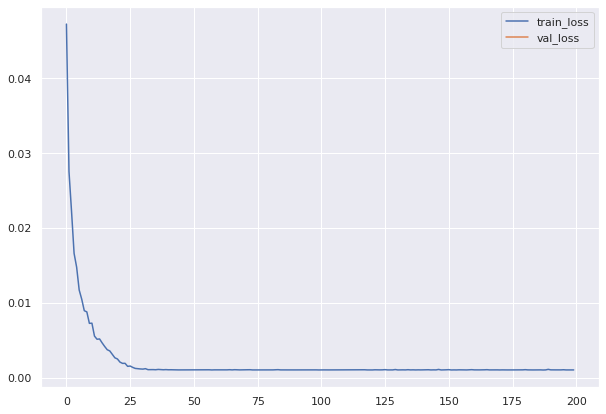

In [894]:
plt.figure()
plt.plot(loss_history_train, label='train_loss')
plt.plot(loss_history_val, label='val_loss')
plt.legend()
plt.show()

In [895]:
model.eval()

EmbeddingBagEmbedder(
  (relu): ReLU()
  (embedding_bag): EmbeddingBag(13733, 100, mode=mean)
  (linear_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
    )
  )
)

# Produce train embeddings and TSNE

In [896]:
from sklearn.preprocessing import normalize

In [897]:
def draw_tsne(model, dataset, df, text_field_name='page_title_stem', label=''):
    embeddings = []
    for ex in tqdm(dataset):
        emb = np.array(model(model.text_field.numericalize([getattr(ex, text_field_name)]))[0].data)
        embeddings.append(emb)
    embeddings = normalize(np.array(embeddings))
    
    tsne = TSNE(
        n_components=2,
        n_jobs=3,
        verbose=True,
    )
    
    emb_ld = tsne.fit_transform(embeddings)
    
    labelled_spec_classes = df.class_
    labelled_spec_classes = labelled_spec_classes.reset_index()
    
    emb_tdf = pd.DataFrame(emb_ld)
    emb_tdf = pd.concat([emb_tdf, labelled_spec_classes], axis=1, ignore_index=True)
    emb_tdf.columns = ['x', 'y', 'original_index', 'class_']

    
    
    plt.figure(figsize=(15, 10))
    plt.title(f'TSNE {label}')
    for class_ in emb_tdf['class_'].sort_values().unique():
        class_ld_df = emb_tdf[emb_tdf.class_==class_]
        plt.scatter(class_ld_df.iloc[:, 0], class_ld_df.iloc[:, 1], label=f'class {class_}')
    plt.show()

HBox(children=(IntProgress(value=0, max=12281), HTML(value='')))

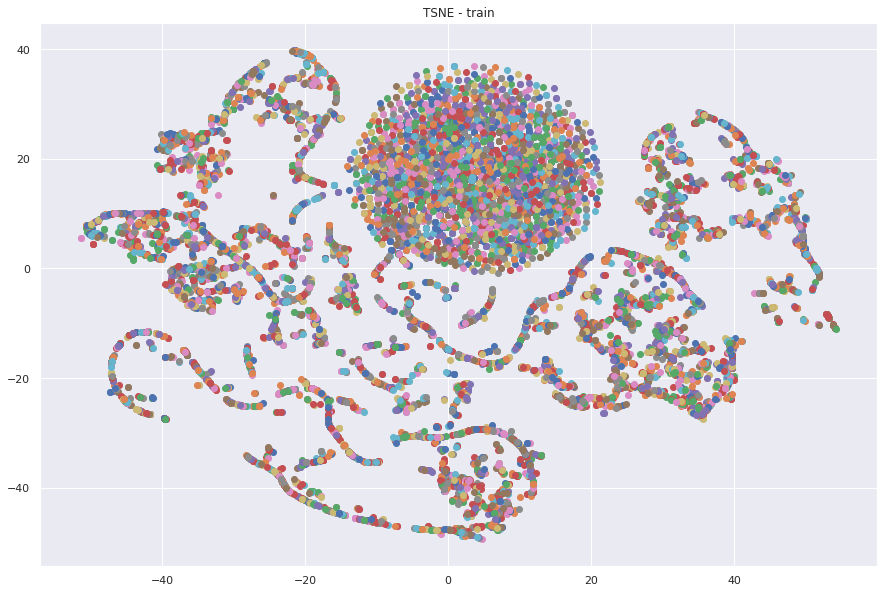

In [898]:
draw_tsne(model, train_dataset, labelled_specs_train, label ='- train')

In [899]:
# draw_tsne(model, val_dataset, labelled_specs_val, label ='- val')

# Produce whole dataset embeddings

In [900]:
embeddings = []
for ex in tqdm(full_dataset):
    emb = np.array(model(model.text_field.numericalize([ex.page_title_stem]))[0].data)
    embeddings.append(emb)
embeddings = normalize(np.array(embeddings))

HBox(children=(IntProgress(value=0, max=29694), HTML(value='')))

In [901]:
emb_df = pd.DataFrame(embeddings)
emb_df.to_csv('../data/processed/embeddings.csv', index=None)

In [902]:
emb_df = pd.read_csv('../data/processed/embeddings.csv')

In [903]:
emb = Embedder(model, specs_df.spec_id.values, specs_df.all_text_stem.values)

In [904]:
emb.fit(emb_df.values)

In [905]:
emb.lookup_texts('canon eo 20d')

array(['may sign cosmet wear fulli oper function intend may floor model return full descript imperfect definit',
       '2 olympus fe 280 digita camera 2 wrist held carri case olympus case bag brand-new applic found retail unless handmad packag non-retail unprint box plastic bag full definit vietnam 8-0-mp fe-280 3x digit slr',
       'free gift kodak easyshar c1530 14-0-mp digit kodak brand-new applic found retail unless handmad packag non-retail unprint box plastic bag full definit 14-0-mp c1530 8908832 3x 3 point shoot',
       'soni mavica fd92 1-2-mp 8x optic zoom 2 5 display digit still 0027242586741 includ soni includ 1-2-mp includ mvc-fd92 mvcfd92 8x 2 5 point shoot 0027242586741',
       'canon power shot a60 digit 2 mega pixel 3x zoom part repair canon flash len part work function intend fulli oper includ item defect way render difficult use item requir servic repair item miss essenti compon full definit malaysia 2-0-mp a60 s2596258 3x 1 5 point shoot',
       'minolta dimag 

In [906]:
emb.save('../models/embedder')